# 합성곱 신경망 Ⅱ
## LeNet-5
* 합성곱(convolutional)과 다운 샘플링(sub-sampling)을 반복적으로 거치면서 마지막에 완전연결층에서 분류를 수행

In [13]:
%load_ext tensorboard

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, Dropout, MaxPooling2D

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
class LeNet(Sequential):
    def __init__(self, input_shape, nb_classes):     
        super().__init__()     # 부모클래스 생성자 호출
        
        self.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), activation='relu',  # 필터 개수, 커널 행과 열, 필터적용 간격, 활성화함수
                       input_shape=input_shape, padding='same'))                 # 입력 이미지 형태, 입력=출력 크기 동일
        self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
        self.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), activation='relu',
                       padding='valid'))
        self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
        self.add(Flatten())
        self.add(Dense(120, activation='relu'))
        self.add(Dense(84, activation='relu'))
        self.add(Dense(nb_classes, activation='softmax'))        
        self.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [3]:
num_classes = 2
model = LeNet((100,100,3), num_classes)
model.summary()

Model: "le_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 6)       456       
_________________________________________________________________
average_pooling2d (AveragePo (None, 50, 50, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 23, 23, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8464)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               1015800   
_________________________________________________________________
dense_1 (Dense)              (None, 84)                10164

In [4]:
# 모델 훈련
EPOCHS = 100
BATCH_SIZE = 32
image_height = 100
image_width = 100
train_dir = 'C:/AI/catanddog/train'
valid_dir = 'C:/AI/catanddog/validation'

# 이미지 변형 (데이터의 양이 적을 때) => 같은 데이터를 여러 각도, 방향, 위치에서 훈련시켜 데이터 수를 늘림
train = ImageDataGenerator(                     
                    rescale = 1./255.,          # 정규화 (안하면 0~255 값으로 나옴(픽셀값))
                    rotation_range = 10,        # 0~10도 범위내에서 원본 이미지 회전
                    width_shift_range = 0.1,    # 10% 비율내에서 수평으로 랜덤하게 평행 이동
                    height_shift_range = 0.1,   # 10% 비율내에서 수직으로 랜덤하게 평행 이동
                    shear_range = 0.1,          # 10% 비율내에서 원본 이미지를 임의로 변형
                    zoom_range = 0.1)           # 0.9~1.1배의 크기로 임의 확대/축소

valid = ImageDataGenerator(rescale = 1./255.)   # 검증용 데이터이기 때문에 변형 불필요.. 정규화만 !!

# 폴더 구조를 가져와서 실제 데이터를 ImageDataGenerator에 채워줌
# 이미지 정보를 포함하고 있지 않음, 설정만 해둔 상태.
train_generator = train.flow_from_directory(train_dir,                                  # 파일 위치
                                            target_size = (image_height, image_width),  # 크기
                                            color_mode = 'rgb',                         # 'grayscale':흑백, 'rgb':색상
                                            batch_size = BATCH_SIZE,                    # 배치당 생성할 이미지 개수
                                            seed = 1,                                   # 난수 랜덤한 값
                                            shuffle = True,                             # 섞기
                                            class_mode = 'categorical')                 # 'binary':클래스 2개, 'categorical':그 이상

valid_generator = valid.flow_from_directory(valid_dir,                                  
                                            target_size = (image_height, image_width),  
                                            color_mode = 'rgb',                         
                                            batch_size = BATCH_SIZE,                    
                                            seed = 7,                                   
                                            shuffle = True,                             
                                            class_mode = 'categorical')                 

train_num = train_generator.samples
valid_num = valid_generator.samples

Found 385 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [5]:
log_dir = 'C:/AI/log_LeNet5'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)
model.fit(train_generator, epochs=EPOCHS,
         validation_data=valid_generator,
         steps_per_epoch=train_num // BATCH_SIZE,
         validation_steps=valid_num // BATCH_SIZE,
         callbacks=[tensorboard_callback],
         verbose=1)

Epoch 1/100
12/12 [==============================] - 2s 184ms/step - loss: 0.7784 - accuracy: 0.5524 - val_loss: 0.7055 - val_accuracy: 0.5000
Epoch 2/100
 8/12 [===================>..........] - ETA: 0s - loss: 0.6961 - accuracy: 0.5312

KeyboardInterrupt: 

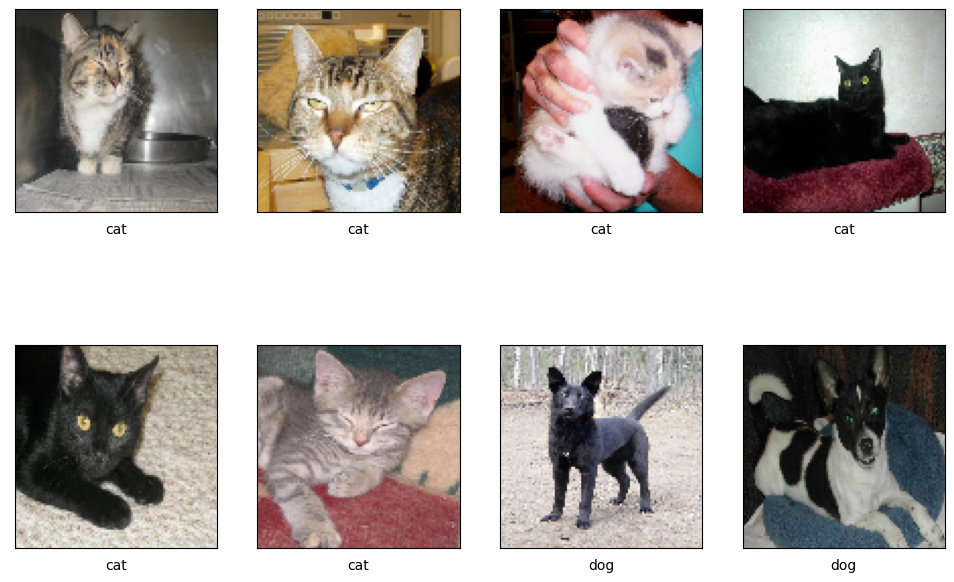

In [6]:
class_names = ['cat', 'dog']
validation, label_batch = next(iter(valid_generator))      # 반복(반복자(리스트 반환 가능 객체)), 
prediction_values = np.argmax(model.predict(validation), axis=-1)   # 검증데이터를 이용해서 예측 
prediction_value = np.argmax(prediction_values, axis=0)

fig = plt.figure(figsize=(12,8))

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(validation[i])
    plt.xticks([])
    plt.yticks([])
    if prediction_values[i] == np.argmax(label_batch[i]):
        plt.xlabel(class_names[prediction_values[i]])
    else :
        plt.xlabel(class_names[1 - prediction_values[i]])
    
plt.show()

## AlexNet
* GPU 2개를 기반으로 한 병렬구조
* 합성곱층 5개, 완전연결층 3개로 구성. 마지막 완전연결층은 1000개로 분류하기 위해 소프트맥스 활성화 함수 사용.

In [19]:
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        self.add(Conv2D(96, kernel_size=(11,11), strides=4, padding='valid',
                        activation='relu', input_shape=input_shape,
                        kernel_initializer='he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid',
                              data_format='channels_last'))
        
        self.add(Conv2D(256, kernel_size=(5,5), strides=1, padding='same',
                        activation='relu', kernel_initializer='he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid',
                              data_format='channels_last'))
        
        self.add(Conv2D(384, kernel_size=(3,3), strides=1, padding='same',
                        activation='relu',
                        kernel_initializer='he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides=1, padding='same',
                        activation='relu',
                        kernel_initializer='he_normal'))
        
        self.add(Conv2D(256, kernel_size=(3,3), strides=1, padding='same',
                        activation='relu',
                        kernel_initializer='he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid',
                              data_format='channels_last'))
        
        self.add(Flatten())
        self.add(Dense(4096, activation='relu'))
        self.add(Dense(4096, activation='relu'))
        self.add(Dense(1000, activation='relu'))
        self.add(Dense(num_classes, activation='softmax'))
        
        self.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [20]:
num_classes = 2
model = AlexNet((100,100,3), num_classes)
model.summary()

Model: "alex_net_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 23, 23, 96)        34944     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 11, 11, 256)       614656    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 5, 5, 384)         885120    
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 5, 5, 384)         1327488   
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 5, 5, 256)         8

In [21]:
log_dir = 'C:/AI/log_AlexNet'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)
model.fit(train_generator, epochs=EPOCHS,
         validation_data=valid_generator,
         steps_per_epoch=train_num // BATCH_SIZE,
         validation_steps=valid_num // BATCH_SIZE,
         callbacks=[tensorboard_callback],
         verbose=1)

Epoch 1/100
12/12 [==============================] - 6s 498ms/step - loss: 6.7386 - accuracy: 0.4974 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/100
12/12 [==============================] - 6s 466ms/step - loss: 0.6942 - accuracy: 0.5156 - val_loss: 0.6922 - val_accuracy: 0.5104
Epoch 3/100
12/12 [==============================] - 6s 482ms/step - loss: 0.6942 - accuracy: 0.4740 - val_loss: 0.6929 - val_accuracy: 0.5104
Epoch 4/100
12/12 [==============================] - 6s 472ms/step - loss: 0.6933 - accuracy: 0.4788 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 5/100
12/12 [==============================] - 6s 465ms/step - loss: 0.6941 - accuracy: 0.4759 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 6/100
12/12 [==============================] - 6s 468ms/step - loss: 0.6951 - accuracy: 0.4703 - val_loss: 0.6930 - val_accuracy: 0.5104
Epoch 7/100
12/12 [==============================] - 6s 469ms/step - loss: 0.6948 - accuracy: 0.4674 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 58/100
12/12 [==============================] - 6s 461ms/step - loss: 0.6920 - accuracy: 0.5354 - val_loss: 0.6929 - val_accuracy: 0.5104
Epoch 59/100
12/12 [==============================] - 6s 463ms/step - loss: 0.6931 - accuracy: 0.5099 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 60/100
12/12 [==============================] - 6s 496ms/step - loss: 0.6923 - accuracy: 0.5286 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 61/100
12/12 [==============================] - 6s 539ms/step - loss: 0.6930 - accuracy: 0.5127 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 62/100
12/12 [==============================] - 6s 488ms/step - loss: 0.6931 - accuracy: 0.5241 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 63/100
12/12 [==============================] - 6s 460ms/step - loss: 0.6922 - accuracy: 0.5326 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 64/100
12/12 [==============================] - 6s 465ms/step - loss: 0.6927 - accuracy: 0.5212 - val_loss: 0.6933 - val_accuracy: